In [21]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## Configuration

In [67]:
CSV_FILE = '../dataset/train.csv'
DATA_DIR = '../dataset/'
DIR_MODELS = '../models/'

DEVICE = 'cuda'
BATCH_SIZE = 16
IMG_SIZE = 140

LR = 0.001 #
EPOCHS = 40
MODEL_NAME = 'efficientnet_b0'

NUM_COR = 4

In [4]:
df = pd.read_csv(CSV_FILE)
df.head()

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant


In [5]:
df['label'].value_counts()

cucumber    63
eggplant    62
mushroom    61
Name: label, dtype: int64

## Understand Dataset

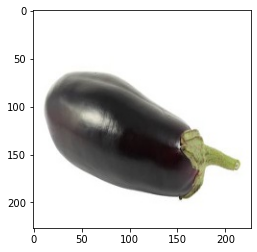

In [6]:
row = df.iloc[10]
img = cv2.imread(DATA_DIR + row.img_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)

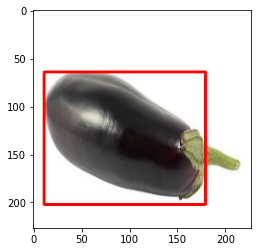

In [7]:
row = df.iloc[10]
img = cv2.imread(DATA_DIR + row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

pl1 = (row.xmin, row.ymin)
pl2 = (row.xmax, row.ymax)
bnd_box_img = cv2.rectangle(img, pl1,pl2,(255,0,0),2)

plt.imshow(bnd_box_img)

In [8]:
train_df, valid_df = train_test_split(df,test_size=0.2,random_state=42)

## Augmentations

In [22]:
import albumentations as A 

In [23]:
train_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip( p = 0.5),
    A.VerticalFlip(p = 0.5),
    A.Rotate() #probability p = 0.5 default
], bbox_params=A.BboxParams(format= 'pascal_voc',label_fields = ['class_labels']))

valid_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip( p = 0.5),
    A.VerticalFlip(p = 0.5),
    A.Rotate()
], bbox_params=A.BboxParams(format= 'pascal_voc', label_fields = ['class_labels']))

## Create Custom Dataset

In [24]:
class ObjLocDataset(torch.utils.data.Dataset):
    
    def __init__(self, df, augmentations = None):
        self.df = df
        self.augmentations = augmentations
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        xmin = row.xmin
        ymin = row.ymin
        xmax = row.xmax
        ymax = row.ymax
        
        bbox = [[xmin,ymin,xmax,ymax]]
        
        img_path = DATA_DIR + row.img_path
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.augmentations:
            data = self.augmentations(image = img, bboxes = bbox, class_labels = [None])
            img = data['image']
            bbox = data['bboxes'][0]
            
        img = torch.from_numpy(img).permute(2,0,1)/255.0 #(h,w,c) --> (c,h,w)
        bbox = torch.Tensor(bbox)
        
        return img,bbox

In [25]:
trainset = ObjLocDataset(train_df,train_augs)
validset = ObjLocDataset(valid_df, valid_augs)

In [26]:
print(f'Total Examples in trainset {len(trainset)}')
print(f'Total Examples in validset {len(validset)}')

Total Examples in trainset 148
Total Examples in validset 38


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


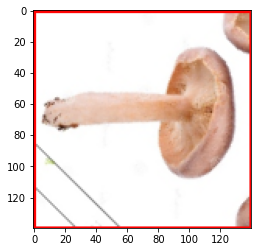

In [58]:
img,bbox = trainset[120]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin),int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_box_img = cv2.rectangle(img.permute(1,2,0).numpy(), pt1,pt2,(255,0,0),2)
plt.imshow(bnd_box_img)

## LOAD Dataset in batches

In [59]:
trainloader = torch.utils.data.DataLoader(trainset,BATCH_SIZE, shuffle=True) 
validloader = torch.utils.data.DataLoader(validset,BATCH_SIZE, shuffle=False) 

print(f'total no. batches in trainloader {len(trainloader)}')
print(f'total no. batches in validloader {len(validloader)}')

total no. batches in trainloader 10
total no. batches in validloader 3


In [60]:
for image, bbox in trainloader:
    break
    
print(f'shape of one batch images {image.shape}')
print(f'shape of one batch bbox {bbox.shape}')

shape of one batch images torch.Size([16, 3, 140, 140])
shape of one batch bbox torch.Size([16, 4])


## CREATE MODEL

In [61]:
from torch import nn
import timm

In [62]:
class ObjLocModel(nn.Module):
    
    def __init__(self):
        super(ObjLocModel, self).__init__()
        
        self.backbone = timm.create_model(MODEL_NAME, pretrained=True, num_classes = 4)
    
    def forward(self, images, gt_bboxes = None):
        bboxes = self.backbone(images)
        
        if gt_bboxes != None:
            loss = nn.MSELoss()(bboxes, gt_bboxes)
            return bboxes, loss
    
        return bboxes
    
model = ObjLocModel()
model.to(DEVICE);

In [63]:
#test
random_img = torch.rand(1, 3, 140, 140).to(DEVICE)
model(random_img)

tensor([[-0.2504,  1.5079, -0.8932,  1.9499]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

## CREATE TRAIN AND EVAL FUNCTION

In [64]:
def train_fn(model, dataloader, optimizer):
    total_loss = 0.0
    model.train() #DROPOUT ON 
    
    for data in tqdm(dataloader):
        
        images, gt_bboxes = data
        images, gt_bboxes =images.to(DEVICE), gt_bboxes.to(DEVICE)
        
        bboxes, loss = model(images, gt_bboxes)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    return total_loss / len(dataloader)

In [65]:
def eval_fn(model, dataloader):
    total_loss = 0.0
    model.eval() #DROPout Off 
    
    with torch.no_grad():
            
        for data in tqdm(dataloader):

            images, gt_bboxes = data
            images, gt_bboxes =images.to(DEVICE), gt_bboxes.to(DEVICE)

            bboxes, loss = model(images, gt_bboxes)
            total_loss += loss.item()

        return total_loss / len(dataloader)

## TRAINING LOOP 

In [69]:
optimizer = torch.optim.Adam(model.parameters(), lr= LR)

In [70]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
    
    train_loss = train_fn(model, trainloader, optimizer)
    valid_loss = eval_fn(model, validloader)
    
    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), DIR_MODELS + 'best_model.pt')
        print('WEIGHTS SAVED')
        best_valid_loss = valid_loss
        
    print(f'Epoch: {i + 1}, Train Loss : {train_loss}, Valid Loss : {valid_loss}')

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 24.38it/s]


WEIGHTS SAVED
Epoch: 1, Train Loss : 5435.506640625, Valid Loss : 3187.2784016927085


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 28.30it/s]


Epoch: 2, Train Loss : 2103.9347290039063, Valid Loss : 3670.4063313802085


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 29.40it/s]


WEIGHTS SAVED
Epoch: 3, Train Loss : 1214.0891967773437, Valid Loss : 735.9217936197916


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 30.92it/s]


WEIGHTS SAVED
Epoch: 4, Train Loss : 819.3945281982421, Valid Loss : 240.5672353108724


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 24.59it/s]


WEIGHTS SAVED
Epoch: 5, Train Loss : 602.8128479003906, Valid Loss : 187.5822296142578


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 30.60it/s]


WEIGHTS SAVED
Epoch: 6, Train Loss : 420.52930603027346, Valid Loss : 151.8389689127604


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 31.24it/s]


Epoch: 7, Train Loss : 328.5815673828125, Valid Loss : 228.59314473470053


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 31.57it/s]


Epoch: 8, Train Loss : 225.54232635498047, Valid Loss : 170.13862101236978


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 29.11it/s]


Epoch: 9, Train Loss : 187.17593383789062, Valid Loss : 162.9584528605143


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 27.89it/s]


Epoch: 10, Train Loss : 164.35150299072265, Valid Loss : 171.44979858398438


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 31.57it/s]


WEIGHTS SAVED
Epoch: 11, Train Loss : 142.4588752746582, Valid Loss : 133.4637451171875


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 31.24it/s]


WEIGHTS SAVED
Epoch: 12, Train Loss : 120.30030136108398, Valid Loss : 123.7552261352539


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 29.26it/s]


WEIGHTS SAVED
Epoch: 13, Train Loss : 106.06764373779296, Valid Loss : 106.43443044026692


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 30.92it/s]


Epoch: 14, Train Loss : 90.71167907714843, Valid Loss : 117.61626688639323


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 29.26it/s]


WEIGHTS SAVED
Epoch: 15, Train Loss : 89.02573318481446, Valid Loss : 95.98652648925781


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 31.24it/s]


Epoch: 16, Train Loss : 91.32997665405273, Valid Loss : 107.9270502726237


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 24.36it/s]


WEIGHTS SAVED
Epoch: 17, Train Loss : 96.05439376831055, Valid Loss : 87.79464467366536


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 28.98it/s]


Epoch: 18, Train Loss : 87.58675880432129, Valid Loss : 103.77027384440105


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 28.56it/s]


Epoch: 19, Train Loss : 81.43330345153808, Valid Loss : 92.06905364990234


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 28.28it/s]


Epoch: 20, Train Loss : 73.63758239746093, Valid Loss : 91.21432495117188


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 28.57it/s]


Epoch: 21, Train Loss : 76.25716361999511, Valid Loss : 96.29030100504558


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 24.99it/s]


Epoch: 22, Train Loss : 60.15501861572265, Valid Loss : 129.39155069986978


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 27.77it/s]


Epoch: 23, Train Loss : 56.2219539642334, Valid Loss : 138.07191467285156


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 23.25it/s]


WEIGHTS SAVED
Epoch: 24, Train Loss : 50.67228603363037, Valid Loss : 69.39710744222005


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 31.57it/s]


Epoch: 25, Train Loss : 57.5054428100586, Valid Loss : 85.70876439412434


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 26.16it/s]


WEIGHTS SAVED
Epoch: 26, Train Loss : 57.60346355438232, Valid Loss : 59.7020517985026


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 27.14it/s]


Epoch: 27, Train Loss : 57.87816619873047, Valid Loss : 251.90832392374674


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 29.12it/s]


Epoch: 28, Train Loss : 45.04768676757813, Valid Loss : 237.23911666870117


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 26.54it/s]


Epoch: 29, Train Loss : 47.984505844116214, Valid Loss : 64.8771235148112


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 29.99it/s]


WEIGHTS SAVED
Epoch: 30, Train Loss : 40.92190322875977, Valid Loss : 58.856309254964195


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 29.70it/s]


Epoch: 31, Train Loss : 48.43263931274414, Valid Loss : 69.43051020304362


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 29.70it/s]


Epoch: 32, Train Loss : 45.56307430267334, Valid Loss : 71.3701171875


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 27.27it/s]


WEIGHTS SAVED
Epoch: 33, Train Loss : 48.39859685897827, Valid Loss : 58.596354166666664


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 22.81it/s]


WEIGHTS SAVED
Epoch: 34, Train Loss : 41.39464702606201, Valid Loss : 55.58276621500651


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 28.57it/s]


Epoch: 35, Train Loss : 52.647248077392575, Valid Loss : 64.35436503092448


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 26.54it/s]


WEIGHTS SAVED
Epoch: 36, Train Loss : 42.427101135253906, Valid Loss : 44.79834810892741


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 29.70it/s]


Epoch: 37, Train Loss : 34.53585224151611, Valid Loss : 55.02205912272135


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 26.31it/s]


Epoch: 38, Train Loss : 40.075870513916016, Valid Loss : 58.15421040852865


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 26.62it/s]


Epoch: 39, Train Loss : 38.57632694244385, Valid Loss : 76.99429066975911


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 28.46it/s]

Epoch: 40, Train Loss : 37.87087688446045, Valid Loss : 86.09638214111328


In [72]:
import utils

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


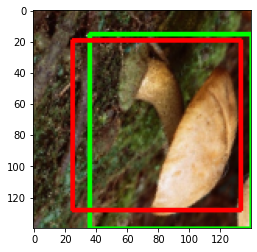

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


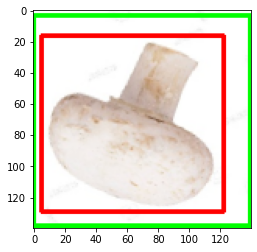

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


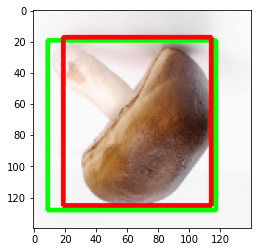

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


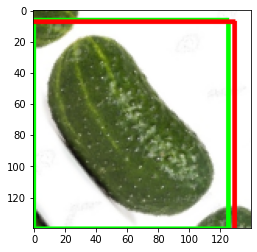

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


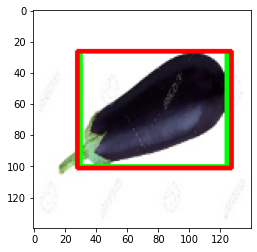

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


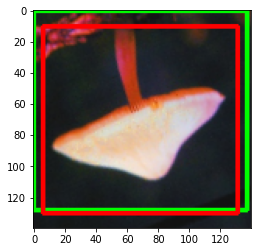

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


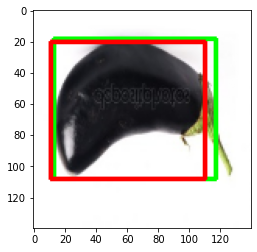

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


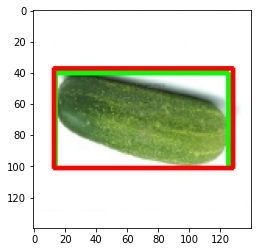

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


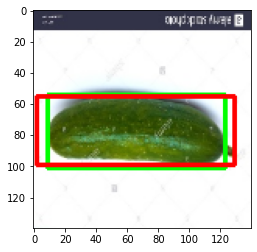

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


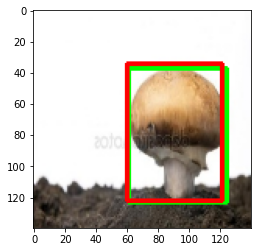

In [80]:
model.load_state_dict(torch.load('../models/best_model.pt'))
model.eval()

with torch.no_grad():
    
    for i in range(0,10):
        
        image, gt_boox = validset[i] #(c, h, w)
        #unsqueeze(0), It is used to add an extra dimension for batch as model takes (batch, channel, height, width)
        image = image.unsqueeze(0).to(DEVICE) #(bs, c,h,w) #
        out_bbox = model(image)

        utils.compare_plots(image, gt_boox, out_bbox)
        plt.show()